In [2]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

In [3]:
# Load the dataset
df = pd.read_csv('../data/daraz.csv')

# add review_id column
df['review_id'] = df.index

In [4]:
# Extract the review_text column
review_texts = df[['review_text','review_id']]

# create a new dataframe with the extracted column
review_texts = pd.DataFrame(review_texts)

# Print the extracted column
print(review_texts)

                                            review_text  review_id
0                                          good product          0
1     Very sturdy and feels safe to use. Highly reco...          1
2     Very sturdy and feels safe to use. Highly reco...          2
3                                                   NaN          3
4     Easy to fold and store. Perfect for my small s...          4
...                                                 ...        ...
4921  A bit heavy to handle, but overall it does the...       4921
4922                                Sturdy and reliable       4922
4923    The ladder feels a bit shakyNot worth the price       4923
4924  The height is just right for cleaning and pain...       4924
4925      Not satisfied. Expected better build quality.       4925

[4926 rows x 2 columns]


In [5]:
# clean text data

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Update stopwords to retain important words like "not" and "no"
important_stopwords = {'not', 'no'}

# Function to clean text and remove stopwords
def clean_and_remove_stopwords(text):
    if pd.isna(text):  # Handle missing values
        return None
    # Step 1: Clean text
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    
    # Step 2: Remove stopwords, but keep important ones like "not"
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words or word in important_stopwords]
    return " ".join(filtered_words)

# Apply the updated cleaning function
review_texts['cleaned_review'] = review_texts['review_text'].apply(clean_and_remove_stopwords)

# review_texts['review_id'] = review_texts.index

print(review_texts.columns)

# Preview the cleaned DataFrame
print(review_texts.head())

# create new dataframe with cleaned text
cleaned_df = review_texts[['review_id', 'cleaned_review']]

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/athukoralagekavishanvishwajith/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


### Using VADER for Sentiment Analysis

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def calculate_sentiment(text):
    if text is None or text.strip() == "":
        return None  # Handle missing or empty text
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Use compound score as overall sentiment

# Apply sentiment analysis to the cleaned review column
review_texts['sentiment_score'] = review_texts['cleaned_review'].apply(calculate_sentiment)

# Add a sentiment label based on the score
def assign_sentiment_label(score):
    if score is None:
        return "neutral"
    elif score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

review_texts['sentiment_label'] = review_texts['sentiment_score'].apply(assign_sentiment_label)

# Preview the DataFrame with sentiment scores and labels
print(review_texts.head())

# Export the DataFrame with sentiment analysis results
review_texts.to_csv("../data/review_texts.csv", index=False)
print("Sentiment analysis results saved to review_texts_with_sentiments.csv.")

                                         review_text  review_id  \
0                                       good product          0   
1  Very sturdy and feels safe to use. Highly reco...          1   
2  Very sturdy and feels safe to use. Highly reco...          2   
3                                                NaN          3   
4  Easy to fold and store. Perfect for my small s...          4   

                             cleaned_review  sentiment_score sentiment_label  
0                              good product           0.4404        positive  
1  sturdy feels safe use highly recommended           0.6115        positive  
2  sturdy feels safe use highly recommended           0.6115        positive  
3                                      None              NaN         neutral  
4       easy fold store perfect small space           0.7650        positive  
Sentiment analysis results saved to review_texts_with_sentiments.csv.


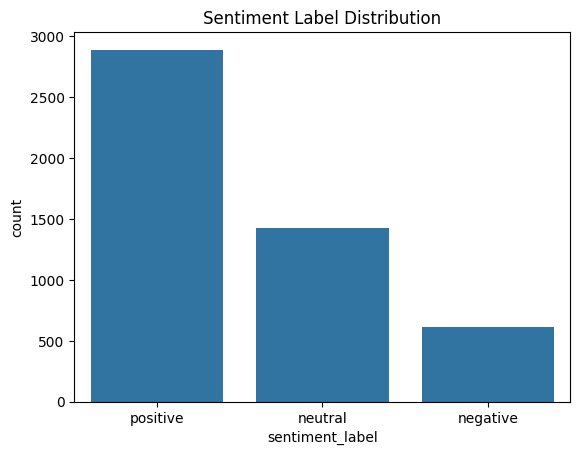

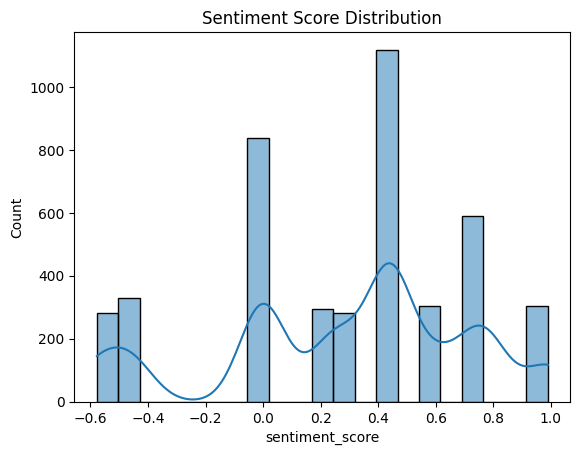

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment label distribution (Positive, Neutral, Negative)
sns.countplot(x='sentiment_label', data=review_texts)
plt.title("Sentiment Label Distribution")
plt.show()

# Plot sentiment score distribution (visualize the overall sentiment)
sns.histplot(review_texts['sentiment_score'], kde=True)
plt.title("Sentiment Score Distribution")
plt.show()


### Correlate Sentiment with Product Success

In [ ]:
# Load the original dataset (assuming it's a CSV)
# original_data = pd.read_csv("../data/daraz.csv")

# Check the columns in the original dataset
print(df.columns)

# Extract the relevant columns (ladder_type, size, and review_id for merging)
relevant_columns = df[['review_id', 'ladder_type', 'size']]

# Preview the relevant columns
print(relevant_columns.head())

Index(['date', 'customer_name', 'review_text', 'review_rating',
       'verified_purchase', 'ladder_type', 'size', 'review_id'],
      dtype='object')
   review_id           ladder_type  size
0          0  multi-purpose ladder  20ft
1          1           step ladder   4ft
2          2           step ladder  10ft
3          3  multi-purpose ladder  16ft
4          4           step ladder   7ft


In [ ]:
# Merge the sentiment data with the relevant columns from the original dataset
merged_data = pd.merge(review_texts[['review_id', 'sentiment_score', 'sentiment_label']], relevant_columns, on='review_id', how='inner')

# Preview the merged dataset
print(merged_data.head())

   review_id  sentiment_score sentiment_label           ladder_type  size
0          0           0.4404        positive  multi-purpose ladder  20ft
1          1           0.6115        positive           step ladder   4ft
2          2           0.6115        positive           step ladder  10ft
3          3              NaN         neutral  multi-purpose ladder  16ft
4          4           0.7650        positive           step ladder   7ft


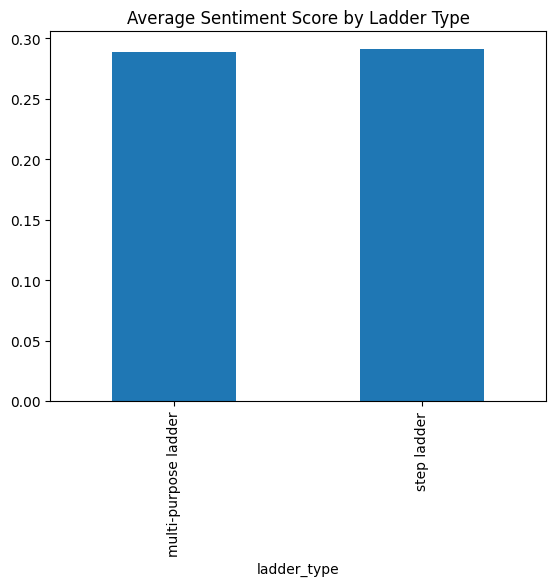

In [ ]:
# Average sentiment score for each ladder_type
ladder_sentiment = merged_data.groupby('ladder_type')['sentiment_score'].mean()

# Visualize sentiment score by ladder type
ladder_sentiment.plot(kind='bar', title='Average Sentiment Score by Ladder Type')
plt.show()


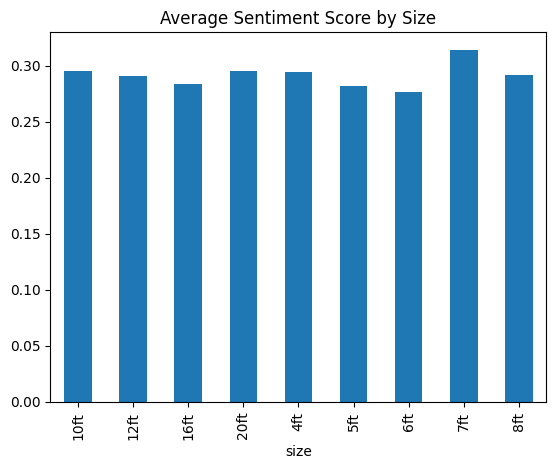

In [ ]:
# Average sentiment score for each size
size_sentiment = merged_data.groupby('size')['sentiment_score'].mean()

# Visualize sentiment score by size
size_sentiment.plot(kind='bar', title='Average Sentiment Score by Size')
plt.show()


In [ ]:
# Convert categorical columns like ladder_type and size into numeric values (if needed for correlation calculation)
merged_data['ladder_type_numeric'] = merged_data['ladder_type'].astype('category').cat.codes
merged_data['size_numeric'] = merged_data['size'].astype('category').cat.codes

# Calculate the correlation between numeric columns
correlation_matrix = merged_data[['sentiment_score', 'ladder_type_numeric', 'size_numeric']].corr()

# Display the correlation matrix
print(correlation_matrix)


                     sentiment_score  ladder_type_numeric  size_numeric
sentiment_score             1.000000            -0.004145      0.002137
ladder_type_numeric        -0.004145             1.000000      0.500522
size_numeric                0.002137             0.500522      1.000000


### Build a Predictive Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report